In [1]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import tensorflow as tf
from functools import reduce

%matplotlib inline

GLOBAL_SEED=1
VERBOSITY=1
TESTING=0

np.random.seed(GLOBAL_SEED)

In [2]:
# useful function for recovering functions in deleted cells
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

In [3]:
# wrapper around tf.get_variable that checks if the variable has already been defined.
# useful for playing around in jupyter. allows you to call cells multiple times
def get_variable_wrap(*args, **kwargs):
    try:
        return tf.get_variable(*args, **kwargs)
    except ValueError:
        tf.get_variable_scope().reuse_variables()
        return tf.get_variable(*args, **kwargs)

## do matrix multiplication with weights and add bias (as in fully connected layer)
def fc_act(x, next_layer_size, act=None, name="fc"):
    nbatches = x.get_shape()[0]
    prev_layer_size = x.get_shape()[1]
    with tf.name_scope("fc"):
        w = get_variable_wrap("weights", [prev_layer_size, next_layer_size], dtype=tf.float32, initializer=tf.random_normal_initializer())
        b = get_variable_wrap("bias", [next_layer_size], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
        o = tf.add(tf.matmul(x, w), b)
        if act: return act(o)
        else: return o

# Sample Data
I want to create 100 bi-variate time-series sampled from the same distribution and split them into train/validation/test 70/20/10, i.e. split into groups of time-series size 14/4/2.

In [4]:
def gen_time_series(n_points):
    time_series = np.array([[np.random.normal(mu*i, sigma*i), 
                        np.random.normal(mu*i, sigma*i/4)] 
                       for i in range(n_points)])
    return time_series

(100, 100, 2)
20000 data values


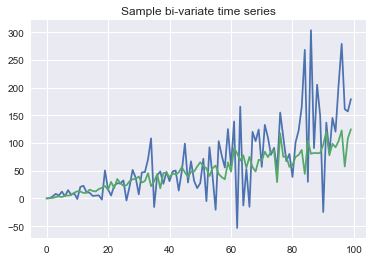

In [5]:
mu=1
sigma=1
n_series=100
n_points = 100
n_features = 2
# multi-variate time-series: 
# x_t ~ [Gaussian(mu*t,sigma*t), Gaussian(mu*t,sigma*t/4)]
# Points X Time X Features
x_data = np.zeros((n_series,n_points,n_features), dtype=np.float32)
for i in range(n_series):
    x_data[i] = gen_time_series(n_points)

if TESTING: x_data_test=x_data[:10]
plt.title("Sample bi-variate time series")
for i in range(n_features):
    plt.plot(x_data[0,:,i]);
print(x_data.shape)
print(reduce(lambda x,y: x*y, list(x_data.shape)), "data values")

x_train = x_data[:70]
x_validate = x_data[70:90]
x_test = x_data[-10:]

# Building Variational RNN

note that all gaussian distribtutions: p(z), q(z|x), p(x|z) should have the same dimensionality, i.e. share z_size

In [6]:
# First I'm going to define the loss functions necessary because they don't depend on anything
def negative_log_likelihood_gaussian(y, mu, sigma):
    """
                a                  b              c
    (1/2)*[ ((y-mu)/sigma)^2 + 2*log(sigma) + log(2*pi) ]
    learn more: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood
    """
#     sigma might be really small. in that case, a & b blow up
    sigma=tf.clip_by_value(sigma, 1e-3,1e10)
    a = tf.square(tf.div(tf.subtract(y,mu), sigma))
    b = 2*tf.log(sigma)
    c = tf.log(2*np.pi)
    return tf.add(tf.add(a,b),c)

def kl_gaussian_gaussian(mu1, sigma1, mu2, sigma2):
    """
            a                  b         c           d
    log(sigma2/sigma1) + (sigma1^2 + (mu1-mu2)^2)/2sigma2^2 - 1/2
    """
    # Note: if sigma1 or sigma2 go to 0, this explodes
    sigma1=tf.clip_by_value(sigma1, 1e-3,1e10)
    sigma2=tf.clip_by_value(sigma2,1e-3,1e10)
    a = tf.log(tf.divide(sigma2,sigma1))
    b = tf.square(sigma1)
    c = tf.square(tf.subtract(mu1,mu2))
    d = 2*tf.square(sigma2)
    e = tf.divide(tf.add(b,c), d)
    return tf.add(a,e) - 0.5

# I will also define a simple wrapper around reshape to flatten the 1st two dimensions of a tensor
def flatten(x):
    return tf.reshape(x, [int(x.shape[0])*int(x.shape[1]), -1])

In [7]:
class VRNN(object):
    """class for VRNN."""
    def __init__(self, input_shape, rnn_size, x_size, x_1_size, 
               z_size, z_1_size, phi_size, prior_size, theta_size, lr=.01):
        self.batch_size = input_shape[0]
        self.ntime_steps = input_shape[1]
        self.nfeatures = input_shape[2]
        
        self.rnn_size = rnn_size
        self.x_size = x_size
        self.x_1_size = x_1_size
        self.z_size = z_size
        self.z_1_size = z_1_size
        self.phi_size = phi_size
        self.prior_size = prior_size
        self.theta_size = theta_size
        self.learning_rate=lr
        
        self.inputs = self._define_input_placeholder(input_shape)
        self._build()

    def _define_input_placeholder(self, input_shape):
        return tf.placeholder(tf.float32, shape=input_shape, name="x_t")

    def _build(self):
        self._init_cell()
        # transpose input so T X N X F instead of N X T X F
        # this allows you to do one time-step at a time for all batches in tf.scan
        self.inputs_t = tf.transpose(self.inputs, [1, 0, 2])
        self.outputs = self._scan_sequence(self.inputs_t)
        
        with tf.name_scope("negative-log-likelihood"):
            self.nll = negative_log_likelihood_gaussian(self.inputs_t, 
                                                        self.outputs[-2], self.outputs[-1])
            self.nll_r = flatten(self.nll)
            tf.summary.scalar("", xent)
        with tf.name_scope("kl-Divergence"):
            self.klgg = kl_gaussian_gaussian(self.outputs[5], self.outputs[6], 
                                             self.outputs[8], self.outputs[9])
            self.klgg_r = flatten(self.klgg)

        with tf.name_scope("objective-function"):
            self.objective = tf.add(tf.reduce_mean(self.nll_r),tf.reduce_mean(self.klgg_r))
        
        with tf.name_scope("train"):
            self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.objective)

    def _init_cell(self):
        with tf.variable_scope("lstm"):
            try:
                self.cell = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple=True)
            except:
                self.cell = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple=True, reuse=True)
        self.state = self.cell.zero_state(batch_size, tf.float32)
    
    def _calculate_prior(self, hidden_state):
        """
        calculate your prior based on your previous state information, i.e. z ~ p(z)
        """
        with tf.variable_scope("prior"):
            prior = fc_act(hidden_state, prior_size, act=tf.nn.relu, name="fc_prior")
        with tf.variable_scope("prior_mu"):
            prior_mu = fc_act(prior, z_size, name="fc_prior_mu")
        with tf.variable_scope("prior_sigma"):
            prior_sigma = fc_act(prior, z_size, act=tf.nn.softplus, name="fc_prior_sigma")
        return [prior, 
                prior_mu, 
                prior_sigma]
        
    def _encode_x(self, x_t, hidden_state):
        """
        infer the latent values given z, i.e. z ~ p(z|x)
        """
        with tf.variable_scope("x_1"):
            x_1 = fc_act(x_t, self.x_1_size, act=tf.nn.relu, name="fc_x_1")
        with tf.variable_scope("phi"):
            phi = fc_act(tf.concat([x_1, hidden_state], axis=1), self.phi_size, act=tf.nn.relu, name="fc_phi")
        with tf.variable_scope("phi_mu"):
            phi_mu = fc_act(phi, self.z_size, name="fc_phi_mu")
        with tf.variable_scope("phi_sigma"):
            phi_sigma = fc_act(phi, self.z_size, act=tf.nn.softplus, name="fc_phi_sigma")
        epsilon = tf.random_normal(shape=[x_t.get_shape().as_list()[0], self.z_size], seed=GLOBAL_SEED)
        # z = mu + epsilon*sigma
        z_t = tf.add(phi_mu, tf.multiply(epsilon, phi_sigma))
        return [x_1, 
                phi,
                phi_mu,
                phi_sigma,
                z_t]
    
    def _decode_z(self, z_t, hidden_state):
        """
        generate the mean and variance for your data from latent values z, i.e. x ~ q(x|z)
        """
        with tf.variable_scope("z_1"):
            z_1 = fc_act(z_t, self.z_1_size, act=tf.nn.relu, name="fc_z_1")
        with tf.variable_scope("theta"):
            theta = fc_act(tf.concat([z_1, hidden_state],axis=1), self.theta_size, act=tf.nn.relu, name="fc_theta")
        with tf.variable_scope("theta_mu"):
            theta_mu = fc_act(theta, self.x_size, name="fc_theta_mu")
        with tf.variable_scope("theta_sigma"):
            theta_sigma = fc_act(theta, self.x_size, act=tf.nn.softplus, name="fc_theta_sigma")
        return [z_1,
                theta,
                theta_mu,
                theta_sigma]
    def _rnn_recurrence(self, x_1, z_1, cell_state, hidden_state):
        """
        use x_1 and z_1 and the previous hidden state to update lstm cell
        """
        try:
            return self.cell(tf.concat([x_1, z_1], axis=1), [cell_state, hidden_state], "rnn")
        except:
            tf.get_variable_scope().reuse_variables()
            return self.cell(tf.concat([x_1, z_1], axis=1), [cell_state, hidden_state], "rnn")

        
    def _vrnn_step(self, vals, x_t):
        """
        A single step on the time-series (or batch) using the VRNN. 
        """
        # I chose to store them all but you don't HAVE to do this. 
        # This is a convenient thing to do however so you can check values later on

        prev_hidden = vals[1]
        # mu_z, sigma_z = f(x, ht-1)
        encoding_vals = [x_1, 
                phi,
                phi_mu,
                phi_sigma,
                z_t] = \
                    self._encode_x(x_t, prev_hidden)
        
        # mu_phi, sigma_phi = f(ht-1)
        prior_vals = [prior, 
                prior_mu, 
                prior_sigma] = \
                    self._calculate_prior(prev_hidden)

        # mu_x , sigma_x = f(z, ht-1)
        decoding_vals = [z_1,
                theta,
                theta_mu,
                theta_sigma] = \
                    self._decode_z(z_t, prev_hidden)
            
        output, state = self._rnn_recurrence(x_1, z_1, vals[0], vals[1])

        return [
            state[0], # vals[0],
            state[1], # vals[1],
            output, # vals[2],
            x_1, # vals[3],
            phi, # vals[4],
            phi_mu, # vals[5],
            phi_sigma, # vals[6],
            prior, # vals[7],
            prior_mu, # vals[8],
            prior_sigma, # vals[9],
            z_t, # vals[10],
            z_1, # vals[11],
            theta, # vals[12],
            theta_mu, # vals[13],
            theta_sigma # vals[14]
        ]
   
    def _scan_sequence(self, sequence):
        with tf.name_scope("scan_input"):
            return tf.scan(self._vrnn_step, sequence, initializer=[
                    self.state[0], # cell_state - 0,
                    self.state[1], # hidden_state - 1,
                    tf.Variable(np.zeros((self.batch_size, self.rnn_size), dtype=np.float32)), # cell_output - 2
                    tf.Variable(np.zeros((self.batch_size, self.x_size), dtype=np.float32)), # x_1 - 3
                    tf.Variable(np.zeros((self.batch_size, self.phi_size), dtype=np.float32)), # phi - 4
                    tf.Variable(np.zeros((self.batch_size, self.z_size), dtype=np.float32)), # phi_mu - 5
                    tf.Variable(np.zeros((self.batch_size, self.z_size), dtype=np.float32)), # phi_sigma - 6
                    tf.Variable(np.zeros((self.batch_size, self.prior_size), dtype=np.float32)), # prior - 7
                    tf.Variable(np.zeros((self.batch_size, self.z_size), dtype=np.float32)), # prior_mu - 8
                    tf.Variable(np.zeros((self.batch_size, self.z_size), dtype=np.float32)), # prior_sigma - 9
                    tf.Variable(np.zeros((self.batch_size, self.z_size), dtype=np.float32)), # z_t - 10
                    tf.Variable(np.zeros((self.batch_size, self.z_size), dtype=np.float32)), # z_1 - 11
                    tf.Variable(np.zeros((self.batch_size, self.theta_size), dtype=np.float32)), # theta - 12
                    tf.Variable(np.zeros((self.batch_size, self.x_size), dtype=np.float32)), # theta_mu - 13
                    tf.Variable(np.zeros((self.batch_size, self.x_size), dtype=np.float32)) # theta_sigma - 14
            ])
    
    @property
    def loss(self): return self.objective
    
    @property
    def x(self): return self.inputs

    @property
    def reconstructions(self): 
        """
        mean and variance to reconstruct x
        transposed from T X N X F to be N X T X F
        """
        return tf.transpose(self.outputs[-2], [1, 0, 2]), tf.transpose(self.outputs[-1], [1, 0, 2])

In [8]:
# test computing latent variable
batch_size=10

rnn_size=20
x_size=x_data.shape[2]
x_1_size=x_data.shape[2]

z_size=15
z_1_size=15

phi_size = 25   # N ~ q(z|x)
prior_size = 25 # N ~ p(z)
theta_size = 25 # N ~ p(x|z)

tf.reset_default_graph()
vrnn = VRNN([batch_size, n_points, n_features], rnn_size, x_size, x_1_size, 
       z_size, z_1_size, phi_size, prior_size, theta_size)    

In [9]:
# define session and model saver
def get_new_session():
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    return sess
sess = get_new_session()

In [10]:
import os
import os.path
import shutil
LOGDIR = "/tmp/test1/"
if os.path.exists(LOGDIR):
    shutil.rmtree(LOGDIR)
writer = tf.summary.FileWriter(LOGDIR)
writer.add_graph(sess.graph)

In [11]:
# TODO: 
# scalar summaries: train loss, validation loss, test loss
# histogram summaries: p(z), p(z|x), p(x|z)


# Define Optimizer

In [ ]:
class Optimizer(object):
    def __init__(self, loss, initial_learning_rate, num_steps_per_decay, decay_rate, max_global_norm=1.0):
        """ Create a simple optimizer.
        
        This optimizer clips gradients and uses vanilla stochastic gradient
        descent with a learning rate that decays exponentially.
        
        Args:
            loss: A 0-D float32 Tensor.
            initial_learning_rate: A float.
            num_steps_per_decay: An integer.
            decay_rate: A float. The factor applied to the learning rate
                every `num_steps_per_decay` steps.
            max_global_norm: A float. If the global gradient norm is less than
                this, do nothing. Otherwise, rescale all gradients so that
                the global norm because `max_global_norm`.
        """
        trainables = tf.trainable_variables()
        grads = tf.gradients(loss, trainables)
        grads, _ = tf.clip_by_global_norm(grads, clip_norm=max_global_norm)
        grad_var_pairs = zip(grads, trainables)
        
        global_step = tf.Variable(0, trainable=False, dtype=tf.int32)
        learning_rate = tf.train.exponential_decay(
            initial_learning_rate, global_step, num_steps_per_decay,
            decay_rate, staircase=True)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        self._optimize_op = optimizer.apply_gradients(grad_var_pairs,
                                                      global_step=global_step)
    
    @property
    def optimization_op(self):
        """ An Operation that takes one optimization step. """
        return self._optimize_op

# Train model

In [ ]:
# writer = tf.summary.FileWriter("/tmp/tensorflow/", graph=tf.get_default_graph())

In [ ]:
tf.summary.scalar('dropout_keep_probability', keep_prob)

In [ ]:
# define optimizer
def get_optimizer():
    train_op = tf.train.AdamOptimizer()
    try:
        optimizer = train_op.minimize(tf.reduce_mean(vrnn.loss))
    except ValueError:
        with tf.variable_scope(tf.get_variable_scope(),reuse=False): 
            optimizer = train_op.minimize(tf.reduce_mean(vrnn.loss))
    return optimizer
optimizer = get_optimizer()

In [ ]:
def compute_loss_on_data(sess, data, model, batch_size):
    losses = []
    nbatches=max(data.shape[0]//batch_size,1)
    for j in range(nbatches):
        batch = x_data[j*batch_size:(j+1)*batch_size]
        loss = sess.run([model.loss], feed_dict={model.x: batch})
        losses.append(loss)
    return np.array(losses).mean()

def train(sess, data, model, optimizer, batch_size):
    losses = []
    nbatches=max(data.shape[0]//batch_size,1)
    for j in range(nbatches):
        batch = x_data[j*batch_size:(j+1)*batch_size]
        _, loss = sess.run([optimizer, model.loss], feed_dict={model.x: batch})
        losses.append(loss)
    return np.array(losses).mean()

def reconstruct(sess, data, model, batch_size):
    mus = []
    sigmas = []
    nbatches=max(data.shape[0]//batch_size,1)
    for j in range(nbatches):
        batch = x_data[j*batch_size:(j+1)*batch_size]
        reconstructions = sess.run([model.reconstructions], feed_dict={model.x: batch})
        mu, sigma = reconstructions[0]
        mus.append(mu)
        sigmas.append(sigma)
    mus=mus[0]
    sigmas=sigmas[0]
    return mus, sigmas

In [ ]:

def train_model(N, sess, x_train, x_validate, vrnn, optimizer, batch_size):
    train_losses = []
    validate_losses = []
    # train the vrnn for N epochs and see the training and validation losses
    for _ in range(N):
        train_loss = train(sess, x_train, vrnn, optimizer, batch_size)
        validate_loss = compute_loss_on_data(sess, x_validate, vrnn, batch_size)
        train_losses.append(train_loss)
        validate_losses.append(validate_loss)
    return train_losses, validate_losses

train_losses, validate_losses = train_model(100, sess, x_train, x_validate, vrnn, optimizer, batch_size)
plt.plot(train_losses);
plt.plot(validate_losses);

In [ ]:
# see how well the vrnn is making predictions
mus, sigmas = reconstruct(sess, x_test, vrnn, batch_size)

In [ ]:
def plot_reconstruction(mus, sigmas, data, index):
    mu_series=mus[index]
    sigma_series=sigmas[index]
    actual = x_test[index]

    reconstruction = np.random.normal(mu_series, sigma_series)
    print("reconstruction", reconstruction.shape)
    print("actual", actual.shape)
    plt.plot(actual[:, 0], label="real");
    plt.plot(reconstruction[:,0], label="reconstruction");
    plt.legend()
    plt.show();
    plt.plot(actual[:, 1], label="real");
    plt.plot(reconstruction[:,1], label="reconstruction");
    plt.legend()
    plt.show();

plot_reconstruction(mus, sigmas, x_test, 0)

In [ ]:
#train for 50 more and see improvement
train_losses, validate_losses = train_model(50, sess, x_train, x_validate, vrnn, optimizer, batch_size)
plt.plot(train_losses);
plt.plot(validate_losses);
plt.show()

In [ ]:
mus, sigmas = reconstruct(sess, x_test, vrnn, batch_size)
plot_reconstruction(mus, sigmas, x_test, 0)

In [ ]:
#train for 1000 more and see improvement
train_losses, validate_losses = train_model(50, sess, x_train, x_validate, vrnn, optimizer, batch_size)
plt.plot(train_losses);
plt.plot(validate_losses);
plt.show()